<a href="https://colab.research.google.com/github/CoderAPS/neural_nets/blob/main/image_segmentation3(20230303_v2).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output
from tqdm import tqdm

from skimage.io import imread, imshow
from skimage.transform import resize

import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow import keras

from keras.models import Model, load_model
from keras.layers import Input, Resizing,Rescaling
from keras.layers.core import Dropout, Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers import Concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K

In [2]:
# split dataset into 85% train, 10% validation and 5% test
# during training create a validation set from training set
dataset,info = tfds.load('oxford_iiit_pet:3.*.*', 
                                split=['train+test[:70%]',
                                       'test[70%:90%]',
                                       'test[90%:]'],
                                with_info=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Shuffling /root/tensorflow_datasets/oxford_iiit_pet/3.2.0.incomplete5C4UNO/oxford_iiit_pet-train.tfrecord*...:…

Generating test examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/oxford_iiit_pet/3.2.0.incomplete5C4UNO/oxford_iiit_pet-test.tfrecord*...: …

Dataset oxford_iiit_pet downloaded and prepared to /root/tensorflow_datasets/oxford_iiit_pet/3.2.0. Subsequent calls will reuse this data.


In [3]:
print(f'Number of images/masks in train set: {len(dataset[0])}')
print(f'Number of images/masks in validation set: {len(dataset[1])}')
print(f'Number of images/masks in test set: {len(dataset[2])}')



Number of images/masks in train set: 6248
Number of images/masks in validation set: 734
Number of images/masks in test set: 367


In [4]:
type(dataset[0])

tensorflow.python.data.ops.dataset_ops.PrefetchDataset

In [ ]:
# how change tf dataset to python list
data = list(dataset[0])

In [5]:
# Function to Normalize pixel values to 0 to 1 from 0 to 255 and subtract 1 from
# the segmentation mask, resulting in labels that are : {0, 1, 2} from {1,2,3}
def normalize(input_image, input_mask):
  input_image = tf.cast(input_image, tf.float32) / 255.0
  input_mask -= 1
  return input_image, input_mask

In [6]:
# Function to resize images and segmentation masks to 128 X 128
def load_image(datapoint):
  input_image = tf.image.resize(datapoint['image'], (128, 128))
  input_mask = tf.image.resize(
    datapoint['segmentation_mask'],
    (128, 128),
    method = tf.image.ResizeMethod.NEAREST_NEIGHBOR,
  )

  input_image, input_mask = normalize(input_image, input_mask)

  return input_image, input_mask

In [7]:
# Normalize image pixels to 0 to 1 and resize images and masks to 128 X 128
train_images = dataset[0].map(load_image, num_parallel_calls=tf.data.AUTOTUNE)
validation_images = dataset[1].map(load_image, num_parallel_calls=tf.data.AUTOTUNE)
test_images = dataset[2].map(load_image, num_parallel_calls=tf.data.AUTOTUNE)


In [8]:
type(train_images)

tensorflow.python.data.ops.dataset_ops.ParallelMapDataset

In [9]:
BUFFER_SIZE = 100
BATCH_SIZE = 64

In [10]:
# Build the input pipeline
train_batches = (
    train_images
    .cache()
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE)
    .prefetch(buffer_size=tf.data.AUTOTUNE)
    )

validation_batches = (
    validation_images
    .cache()
    .batch(BATCH_SIZE)
    .prefetch(buffer_size=tf.data.AUTOTUNE)
    )

test_batches = (
    test_images
    .cache()
    .batch(BATCH_SIZE)
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)

In [11]:
def display(data_list):
  plt.figure(figsize=(16,8))
  title = ['Input Image', 'True Mask', 'Predicted Mask']

  for i in range(len(data_list)):
    plt.subplot(1, len(data_list), i+1)
    plt.title(title[i])
    plt.imshow(data_list[i])
    plt.axis('off')
  plt.show()


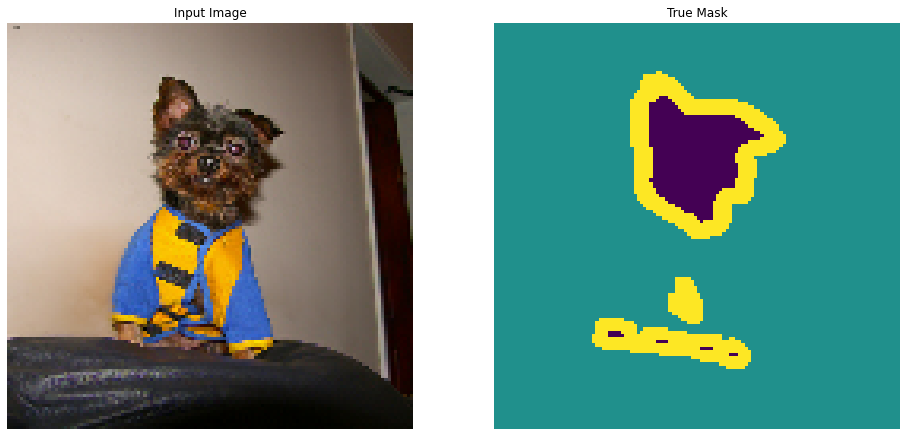

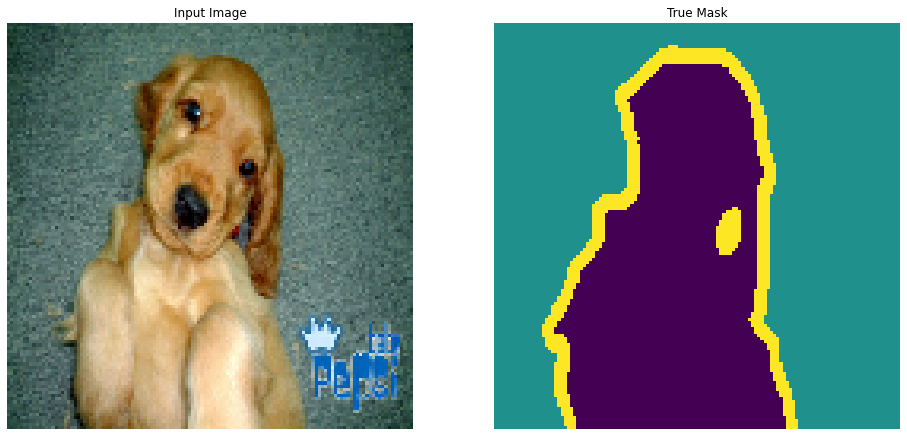

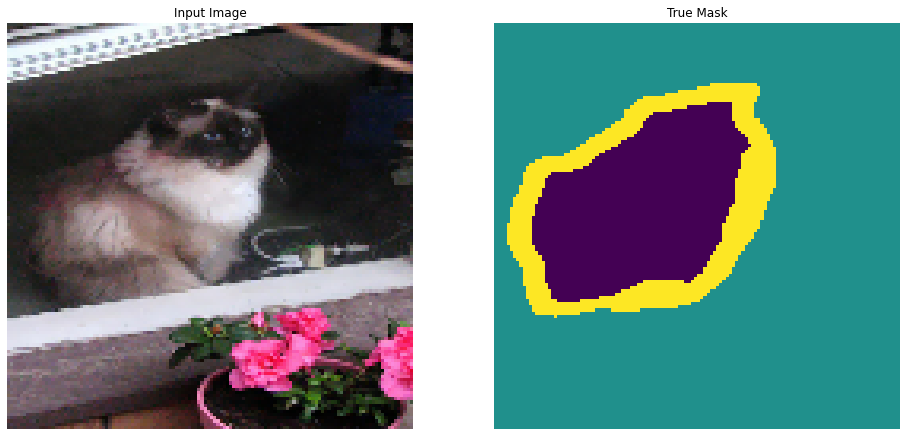

In [12]:
for images, masks in train_batches.take(3):
  sample_image, sample_mask = images[0], masks[0]
  display([sample_image, sample_mask])

In [13]:
IMG_HEIGHT = 128
IMG_WIDTH = 128
IMG_CHANNELS = 3

In [14]:
def get_model():
  inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))

  # Downsampling (encodere)
  c1 = Conv2D(filters=16, kernel_size=(3, 3), activation='elu', 
              kernel_initializer='he_normal', padding='same') (inputs)
  c1 = Dropout(0.1) (c1)
  c1 = Conv2D(filters=16, kernel_size=(3, 3), activation='elu', 
              kernel_initializer='he_normal', padding='same') (c1)
  p1 = MaxPooling2D((2, 2)) (c1)

  c2 = Conv2D(filters=32, kernel_size=(3, 3), activation='elu', 
              kernel_initializer='he_normal', padding='same') (p1)
  c2 = Dropout(0.1) (c2)
  c2 = Conv2D(filters=32, kernel_size=(3, 3), activation='elu', 
              kernel_initializer='he_normal', padding='same') (c2)
  p2 = MaxPooling2D((2, 2)) (c2)

  c3 = Conv2D(filters=64, kernel_size=(3, 3), activation='elu', 
              kernel_initializer='he_normal', padding='same') (p2)
  c3 = Dropout(0.2) (c3)
  c3 = Conv2D(filters=64, kernel_size=(3, 3), activation='elu', 
              kernel_initializer='he_normal', padding='same') (c3)
  p3 = MaxPooling2D((2, 2)) (c3)

  c4 = Conv2D(filters=128, kernel_size=(3, 3), activation='elu', 
              kernel_initializer='he_normal', padding='same') (p3)
  c4 = Dropout(0.2) (c4)
  c4 = Conv2D(filters=128, kernel_size=(3, 3), activation='elu', 
              kernel_initializer='he_normal', padding='same') (c4)
  p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

  c5 = Conv2D(filters=256, kernel_size=(3, 3), activation='elu', 
              kernel_initializer='he_normal', padding='same') (p4)
  c5 = Dropout(0.3) (c5)
  c5 = Conv2D(filters=256, kernel_size=(3, 3), activation='elu', 
              kernel_initializer='he_normal', padding='same') (c5)

  # upsampling (Decoder)
  # may need to change kernel_size to (3,3)?
  u6 = Conv2DTranspose(filters=128, kernel_size=(2, 2), strides=(2, 2), 
                       padding='same') (c5)
  u6 = Concatenate()([u6, c4])
  c6 = Conv2D(filters=128, kernel_size=(3, 3),activation='elu', 
              kernel_initializer='he_normal', padding='same') (u6)
  c6 = Dropout(0.2) (c6)
  c6 = Conv2D(filters=128, kernel_size=(3, 3), activation='elu', 
              kernel_initializer='he_normal', padding='same') (c6)

  u7 = Conv2DTranspose(filters=64, kernel_size=(2, 2), strides=(2, 2), 
                       padding='same') (c6)
  u7 = Concatenate()([u7, c3])
  c7 = Conv2D(filters=64, kernel_size=(3, 3), activation='elu', 
              kernel_initializer='he_normal', padding='same') (u7)
  c7 = Dropout(0.2) (c7)
  c7 = Conv2D(filters=64, kernel_size=(3, 3), activation='elu', 
              kernel_initializer='he_normal', padding='same') (c7)

  u8 = Conv2DTranspose(filters=32, kernel_size=(2, 2), strides=(2, 2), 
                       padding='same') (c7)
  u8 = Concatenate()([u8, c2])
  c8 = Conv2D(filters=32, kernel_size=(3, 3), activation='elu', 
              kernel_initializer='he_normal', padding='same') (u8)
  c8 = Dropout(0.1) (c8)
  c8 = Conv2D(filters=32, kernel_size=(3, 3), activation='elu', 
              kernel_initializer='he_normal', padding='same') (c8)

  u9 = Conv2DTranspose(filters=16, kernel_size=(2, 2), strides=(2, 2), 
                       padding='same') (c8)
  u9 = Concatenate()([u9,c1]) # get rid of (axis=3)?
  c9 = Conv2D(filters=16, kernel_size=(3, 3), activation='elu', 
              kernel_initializer='he_normal', padding='same') (u9)
  c9 = Dropout(0.1) (c9)
  c9 = Conv2D(filters=16, kernel_size=(3, 3), activation='elu', 
              kernel_initializer='he_normal', padding='same') (c9)

  # Last / top layer
  outputs = Conv2D(filters=3, kernel_size=(1, 1),activation='tanh') (c9)
  #outputs = Conv2DTranspose(filters=3, kernel_size=(3,3), strides=(2,2),
  #    padding='same')(c9)

  model = Model(inputs=[inputs], outputs=[outputs])

  return model

In [15]:
unet_model = get_model()

In [ ]:
# how add IoU metric 
# possible source1: https://stackoverflow.com/questions/65974208/intersection-over-union-iou-metric-for-multi-class-semantic-segmentation-task
# (possible source2): https://www.kaggle.com/code/vbookshelf/keras-iou-metric-implemented-without-tensor-drama
# possible source3: https://www.kaggle.com/code/keegil/keras-u-net-starter-lb-0-277/notebook

In [16]:
# see: https://stackoverflow.com/questions/60507120/how-to-correctly-use-the-tensorflow-meaniou-metric
# see: https://keras.io/api/metrics/segmentation_metrics/ 

num_class = 3
calc_mean_iou = tf.keras.metrics.MeanIoU(num_classes=num_class)

def mean_iou(y_true,y_pred):
  
  y_pred = tf.math.argmax(y_pred, axis=-1)
  y_pred = y_pred[..., tf.newaxis]

  calc_mean_iou.update_state(y_true,y_pred)

  return calc_mean_iou.result()

  


In [ ]:
actualls = [[2],[2],[1],[0],[0]]

predictions = [[0.7,0.1,0.2],
               [0.1,0.6,0.3],
               [0.2,0.6,0.2],
               [0.7,0.1,0.2],
               [0.5,0.2,.3]]

preds = tf.math.argmax(predictions, axis=-1)
preds = preds[...,tf.newaxis]
preds

<tf.Tensor: shape=(5, 1), dtype=int64, numpy=
array([[0],
       [1],
       [1],
       [0],
       [0]])>

In [ ]:
m = tf.keras.metrics.MeanIoU(num_classes=3)
m.update_state(actualls, preds)
m.result().numpy()


0.38888893

In [ ]:
result = mean_iou(actualls,predictions)
result.numpy()

NameError: ignored

In [28]:
unet_model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy',
                       tf.keras.metrics.IoU(num_classes=3,target_class_ids=[0,1,2],
                                                  sparse_y_pred = False)])

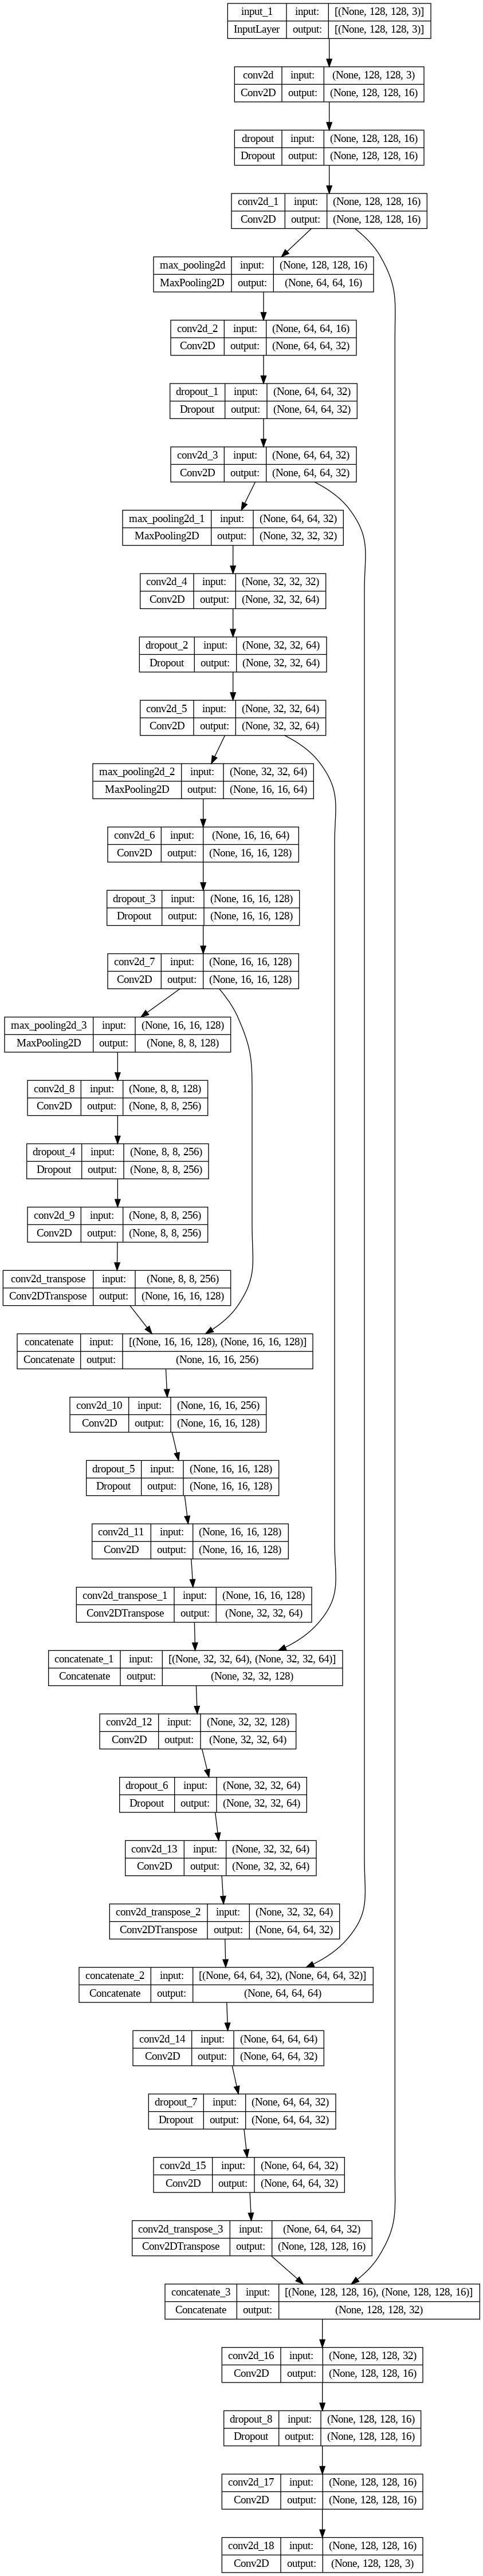

In [ ]:
tf.keras.utils.plot_model(unet_model, show_shapes=True)

In [ ]:
unet_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 128, 128, 16  448         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 dropout (Dropout)              (None, 128, 128, 16  0           ['conv2d[0][0]']                 
                                )                                                             

In [29]:
def create_mask(pred_mask):
  #print('1:pred mask shape: ',pred_mask.shape)
  #print('1:pred mask -> first 10 pixels: ',pred_mask[0,0][:10])
  pred_mask = tf.math.argmax(pred_mask, axis=-1)
  #print('2:pred mask shape: ',pred_mask.shape)
  #print('2:pred mask -> first 10 pixels: ',pred_mask[0,0][:10])
  pred_mask = pred_mask[..., tf.newaxis]
  #print('3:pred mask shape: ',pred_mask.shape)
  #print('3:pred mask -> first 10 pixels: ',pred_mask[0,0][:10])

  return pred_mask[0]

In [30]:
def show_predictions(dataset=None, num=1):
  #print('sample mask shape: ',sample_mask.shape)
  #print('sample mask -> first 10 pixels: ',sample_mask[0,:10])
  if dataset:
    for image, mask in dataset.take(num):
      pred_mask = unet_model.predict(image)
      display([image[0], mask[0], create_mask(pred_mask)])
  else:
    display([sample_image, sample_mask,
             create_mask(unet_model.predict(sample_image[tf.newaxis, ...]))])

In [ ]:
arr = [
 [-0.33716238, 0.1598231, 0.57919985],
 [-0.10913724, 0.06364131, 0.09261815],
 [-0.13953206, -0.03995966, 0.07177228],
 [-0.12199199, 0.00913031, 0.24474134],
 [-0.12963006, 0.5019889, -0.04280034],
 [ 0.0086791, -0.03630042, 0.18792495],
 [-0.58989996, 0.18462937, 0.551403  ],
 [-0.5629541,  0.16201405, 0.27976698],
 [-0.6096558, 0.13429327, 0.5282434 ],
 [-0.3871454, -0.08930931, 0.5325304 ]]
arr

[[-0.33716238, 0.1598231, 0.57919985],
 [-0.10913724, 0.06364131, 0.09261815],
 [-0.13953206, -0.03995966, 0.07177228],
 [-0.12199199, 0.00913031, 0.24474134],
 [-0.12963006, 0.5019889, -0.04280034],
 [0.0086791, -0.03630042, 0.18792495],
 [-0.58989996, 0.18462937, 0.551403],
 [-0.5629541, 0.16201405, 0.27976698],
 [-0.6096558, 0.13429327, 0.5282434],
 [-0.3871454, -0.08930931, 0.5325304]]

In [ ]:
arr_argmax = tf.math.argmax(arr,axis=-1)
arr_argmax

<tf.Tensor: shape=(10,), dtype=int64, numpy=array([2, 2, 2, 2, 1, 2, 2, 2, 2, 2])>

In [ ]:
# use of: tf.newaxis
# https://stackoverflow.com/questions/64312153/tf-newaxis-operation-in-tensorflow
a = tf.constant([100])
print(a.shape) ## (1)
expanded_1 = tf.expand_dims(a,axis=1)
print(expanded_1.shape) ## (1,1)
expanded_2 = a[:, tf.newaxis]
print(expanded_2.shape) ## (1,1)

(1,)
(1, 1)
(1, 1)


1/1 [==============================] - 0s 238ms/step


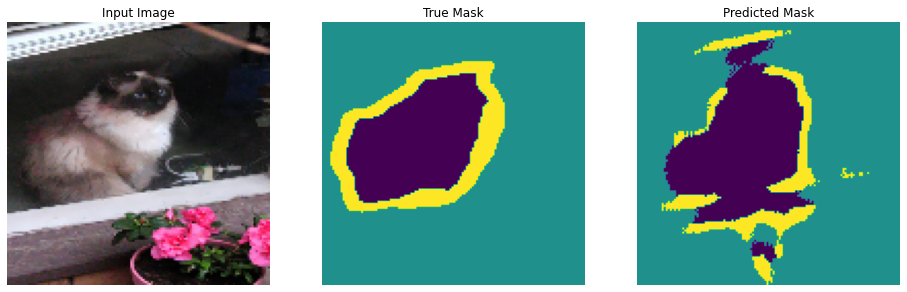

In [31]:
show_predictions()

In [32]:
class DisplayCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
    clear_output(wait=True)
    show_predictions()
    print ('\nSample Prediction after epoch {}\n'.format(epoch+1))

In [33]:
filepath = "unet_model.h5"

earlystopper = EarlyStopping(patience=5, verbose=1)

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, 
                             save_best_only=True, mode='min')

callbacks_list = [earlystopper,checkpoint,DisplayCallback()]

1/1 [==============================] - 0s 25ms/step


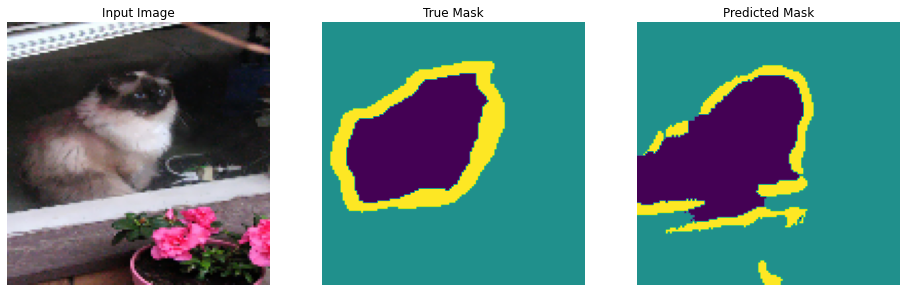


Sample Prediction after epoch 3

98/98 [==============================] - 20s 200ms/step - loss: 0.5010 - accuracy: 0.8450 - io_u: 0.6293 - val_loss: 0.4910 - val_accuracy: 0.8507 - val_io_u: 0.6480


In [34]:
EPOCHS = 3


model_history = unet_model.fit(train_batches, epochs=EPOCHS,
                          validation_data=test_batches,
                          callbacks=callbacks_list)

In [25]:
model_history.history.keys()



dict_keys(['loss', 'accuracy', 'mean_io_u_1', 'val_loss', 'val_accuracy', 'val_mean_io_u_1'])

In [ ]:
result = unet_model.predict(test_batches)

6/6 [==============================] - 0s 58ms/step


In [ ]:
result[366][127][127]

array([-0.99139255,  0.99377126, -0.90419036], dtype=float32)

AttributeError: ignored

In [ ]:
def show_history(model_history):
  
  acc = model_history.history['accuracy']
  val_acc = model_history.history['val_accuracy']

  loss = model_history.history['loss']
  val_loss = model_history.history['val_loss']
  

  epochs_range = model_history.epoch

  plt.figure(figsize=(12, 4))
  plt.subplot(1, 2, 1)
  plt.plot(epochs_range, acc, label='Training Accuracy')
  plt.plot(epochs_range, val_acc, label='Validation Accuracy')


  plt.legend(loc='lower right')
  plt.title('Training and Validation Accuracy')

  plt.subplot(1, 2, 2)
  plt.plot(epochs_range, loss, label='Training Loss')
  plt.plot(epochs_range, val_loss, label='Validation Loss')

    
  plt.legend(loc='upper right')
  plt.title('Training and Validation Loss')
  plt.show()

  train_acc = model_history.history['accuracy'][-1]
  val_acc = model_history.history['val_accuracy'][-1]
  train_loss = model_history.history['loss'][-1]
  val_loss = model_history.history['val_loss'][-1]

  print(f'Training accuracy: {train_acc:.3f}\tTraining loss: {train_loss:.3f}')
  print(f'Validation accuracy: {val_acc:.3f}\tTraining loss: {val_loss:.3f}')


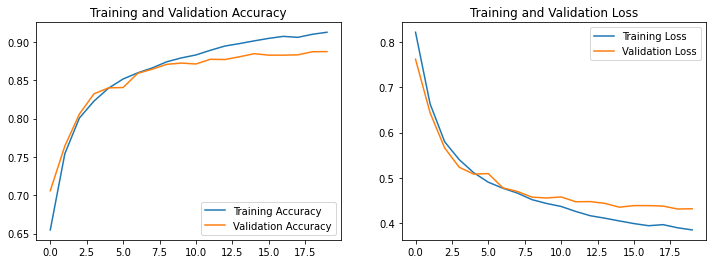

Training accuracy: 0.912	Training loss: 0.385
Validation accuracy: 0.887	Training loss: 0.432


In [ ]:
show_history(model_history)